In [ ]:
import numpy as np
import pandas as pd
import pickle
import os, time

In [2]:
with open('routerbench/routerbench_raw.pkl', 'rb') as file:
    data_raw = pickle.load(file)

with open('routerbench/routerbench_0shot.pkl', 'rb') as file:
    data0 = pickle.load(file)

with open('routerbench/routerbench_5shot.pkl', 'rb') as file:
    data5 = pickle.load(file)

with open('routerbench/data/embedding_cache_all-MiniLM-L12-v2.pkl', 'rb') as file:
    embed_all = pickle.load(file)

with open('routerbench/data/routerbench/input_wide__04-11-04__routerbench.pkl', 'rb') as file:
    embed_wide = pickle.load(file)

#data = np.load("sprout_data_train_test.npy", allow_pickle=True).item()

In [3]:
embeddings = [i['embedding'] for i in embed_all]
np.array(embeddings).shape

(36511, 384)

In [ ]:
llms = ['WizardLM/WizardLM-13B-V1.2', 'claude-instant-v1', 'claude-v1', 'claude-v2', 'gpt-3.5-turbo-1106',
       'gpt-4-1106-preview', 'meta/code-llama-instruct-34b-chat',
       'meta/llama-2-70b-chat', 'mistralai/mistral-7b-chat',
       'mistralai/mixtral-8x7b-chat', 'zero-one-ai/Yi-34B-Chat']

llms_short = ['WizardLM 13B', 'Claude Instant v1', 'Claude v1', 'Claude v2', 'GPT-3.5',
       'GPT-4', 'Code Llama 34b',
       'Llama 70b', 'Mistral 7b',
       'Mixtral 8x7b', 'Yi 34B']

llms_short = ['WizardLM 13B', 'Claude Instant v1', 'Claude v1', 'Claude v2', 'GPT-3.5',
       'GPT-4', 'Code Llama 34b',
       'Llama 70b', 'Mistral 7b',
       'Mixtral 8x7b', 'zero-one-yi-34B']

llm_short_name = {}

for i in range(len(llms_short)):
    llm_short_name[llms[i]] = llms_short[i]

to_exclude = []

for cat in pd.unique(data5['eval_name']):

    if cat.startswith('mmlu'):
        pass
    elif cat.startswith('mtbench'):
        pass
    elif cat.startswith('mbpp'):
        pass
    elif cat.startswith('hellaswag'):
        pass
    elif cat.startswith('winogrande'):
        pass
    elif cat.startswith('arc-challenge'):
        pass
    elif cat.startswith('grade-school-math'):
        pass
    else:
        to_exclude.append(cat)

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def get_nan_row_indices(arr):
    """
    Returns the indices of rows containing NaN values in a NumPy array.

    Args:
        arr (np.ndarray): The input NumPy array.

    Returns:
        np.ndarray: An array of row indices containing NaN values.
    """
    nan_mask = np.isnan(arr)
    row_has_nan = np.any(nan_mask, axis=1)
    return np.where(row_has_nan)[0]



list_append = ['WizardLM/WizardLM-13B-V1.2',
       'claude-instant-v1', 'claude-v1', 'claude-v2', 'gpt-3.5-turbo-1106',
       'gpt-4-1106-preview', 'meta/code-llama-instruct-34b-chat',
       'meta/llama-2-70b-chat', 'mistralai/mistral-7b-chat',
       'mistralai/mixtral-8x7b-chat', 'zero-one-ai/Yi-34B-Chat',
       'WizardLM/WizardLM-13B-V1.2|total_cost', 'claude-instant-v1|total_cost',
       'claude-v1|total_cost', 'claude-v2|total_cost', 
       'gpt-3.5-turbo-1106|total_cost', 
       'gpt-4-1106-preview|total_cost', 'meta/code-llama-instruct-34b-chat|total_cost', 'meta/llama-2-70b-chat|total_cost',
       'mistralai/mistral-7b-chat|total_cost', 'mistralai/mixtral-8x7b-chat|total_cost',
       'zero-one-ai/Yi-34B-Chat|total_cost']   


filter_categories = 1

if filter_categories:
    mask_to_keep = ~data5['eval_name'].isin(to_exclude)
    data5 = data5[mask_to_keep].reset_index()

    embeddings_array = np.array(embeddings)
    embeddings = embeddings_array[mask_to_keep].tolist()




y_cost = np.zeros((len(embeddings), 11))
y_acc = np.zeros((len(embeddings), 11))

for i in range(len(embeddings)):
    for j in range(11):
        y_cost[i, j] =  data5[list_append[j+11]][i]
        y_acc[i, j] = data5[list_append[j]][i]

X_train, X_test, y_acc_train, y_acc_test, y_cost_train, y_cost_test, eval_train, eval_test = train_test_split(embeddings, y_acc, y_cost, data5['eval_name'], stratify=data5['eval_name'], test_size=0.2, random_state=42)

__indices_to_delete_train = get_nan_row_indices(y_acc_train)
__indices_to_delete_test = get_nan_row_indices(y_acc_test)


X_train = np.delete(X_train, __indices_to_delete_train, axis=0)
X_test = np.delete(X_test, __indices_to_delete_test, axis=0)
y_cost_train = np.delete(y_cost_train, __indices_to_delete_train, axis=0)
y_cost_test = np.delete(y_cost_test, __indices_to_delete_test, axis=0)
eval_train = eval_train.reset_index(drop=True).drop(__indices_to_delete_train).reset_index(drop=True)
eval_test =  eval_test.reset_index(drop=True).drop(__indices_to_delete_test).reset_index(drop=True)
y_acc_train = np.delete(y_acc_train, __indices_to_delete_train, axis=0)
y_acc_test = np.delete(y_acc_test, __indices_to_delete_test, axis=0)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from skactiveml.regressor import NICKernelRegressor


regressors = dict.fromkeys(llms, 0)


for llm in llms:
    idx = list_append.index(llm)
    regressors[llm] = NICKernelRegressor(metric_dict={'gamma': 15.0})
    regressors[llm].fit(X_train, y_acc_train[:, idx])

In [10]:
def score_auc(y_acc_test, y_cost_test, y_acc_pred, y_cost_pred, lam):

    n = y_acc_test.shape[0]
    
    y_cost_pred_ = y_cost_pred/np.max(y_cost_pred)
    y_cost_test_ = y_cost_test/np.max(y_cost_test)
    
    model_idx = ((1 - lam) * y_acc_pred - lam * y_cost_pred_).argmax(axis = 1)
    
    crit = np.zeros(n)
    final_acc = np.zeros(n)
    final_cost = np.zeros(n)
    
    crit = (1 - lam) * y_acc_test[np.arange(n), model_idx] - lam * y_cost_test_[np.arange(n), model_idx]
    
    final_acc = y_acc_test[np.arange(n), model_idx]
    
    final_cost = y_cost_test_[np.arange(n), model_idx]

    return np.mean(final_acc), np.mean(final_cost)

In [20]:
acc_true1 = np.zeros(len(list(np.arange(0, 1.001, 0.0001))))
cost_true1 = np.zeros(len(list(np.arange(0, 1.001, 0.0001))))

y_acc_pred = np.zeros(y_acc_test.shape)

for llm in llms:  
    idx = list_append.index(llm)
    y_acc_pred[:, idx] = regressors[llm].predict(X_test)

for lam, i in zip(np.arange(0, 1.001, 0.0001), range(len(list(np.arange(0, 1.001, 0.0001))))):

    x = score_auc(y_acc_test, y_cost_test, y_acc_pred, y_cost_test, lam)
    acc_true1[i], cost_true1[i], = x[0], x[1] 


In [ ]:
acc_true2 = np.zeros(len(list(np.arange(0, 1.001, 0.0001))))
cost_true2 = np.zeros(len(list(np.arange(0, 1.001, 0.0001))))

for lam, i in zip(np.arange(0, 1.001, 0.0001), range(len(list(np.arange(0, 1.001, 0.0001))))):

    x = score_auc(y_acc_test, y_cost_test, y_acc_test, y_cost_test, lam)
    acc_true2[i], cost_true2[i], = x[0], x[1] 

In [ ]:
acc_true_zero = np.zeros(len(list(np.arange(0, 1.001, 0.0001))))
cost_true_zero = np.zeros(len(list(np.arange(0, 1.001, 0.0001))))

y_acc_pred__ = np.zeros(y_acc_pred.shape)


llms = ['WizardLM/WizardLM-13B-V1.2', 'claude-instant-v1', 'claude-v1', 'claude-v2', 'gpt-3.5-turbo-1106',
       'gpt-4-1106-preview', 'meta/code-llama-instruct-34b-chat',
       'meta/llama-2-70b-chat', 'mistralai/mistral-7b-chat',
       'mistralai/mixtral-8x7b-chat', 'zero-one-ai/Yi-34B-Chat']

for llm in llms: 
    if llm == 'zero-one-ai/Yi-34B-Chat':
        pass
    else:
        idx = list_append.index(llm)
        y_acc_pred__[:, idx] = y_acc_pred[:, idx]


for lam, i in zip(np.arange(0, 1.001, 0.0001), range(len(list(np.arange(0, 1.001, 0.0001))))):

    x = score_auc(y_acc_test, y_cost_test, y_acc_pred__, y_cost_test, lam)
    acc_true_zero[i], cost_true_zero[i], = x[0], x[1] 


llm_acc_cost = dict.fromkeys(llms, 0)
for llm in llms:
    idx = list_append.index(llm)
    llm_acc_cost[llm] = (np.mean(y_acc_test[:, idx]), np.mean(y_cost_test[:, idx]/np.max(y_cost_test)))

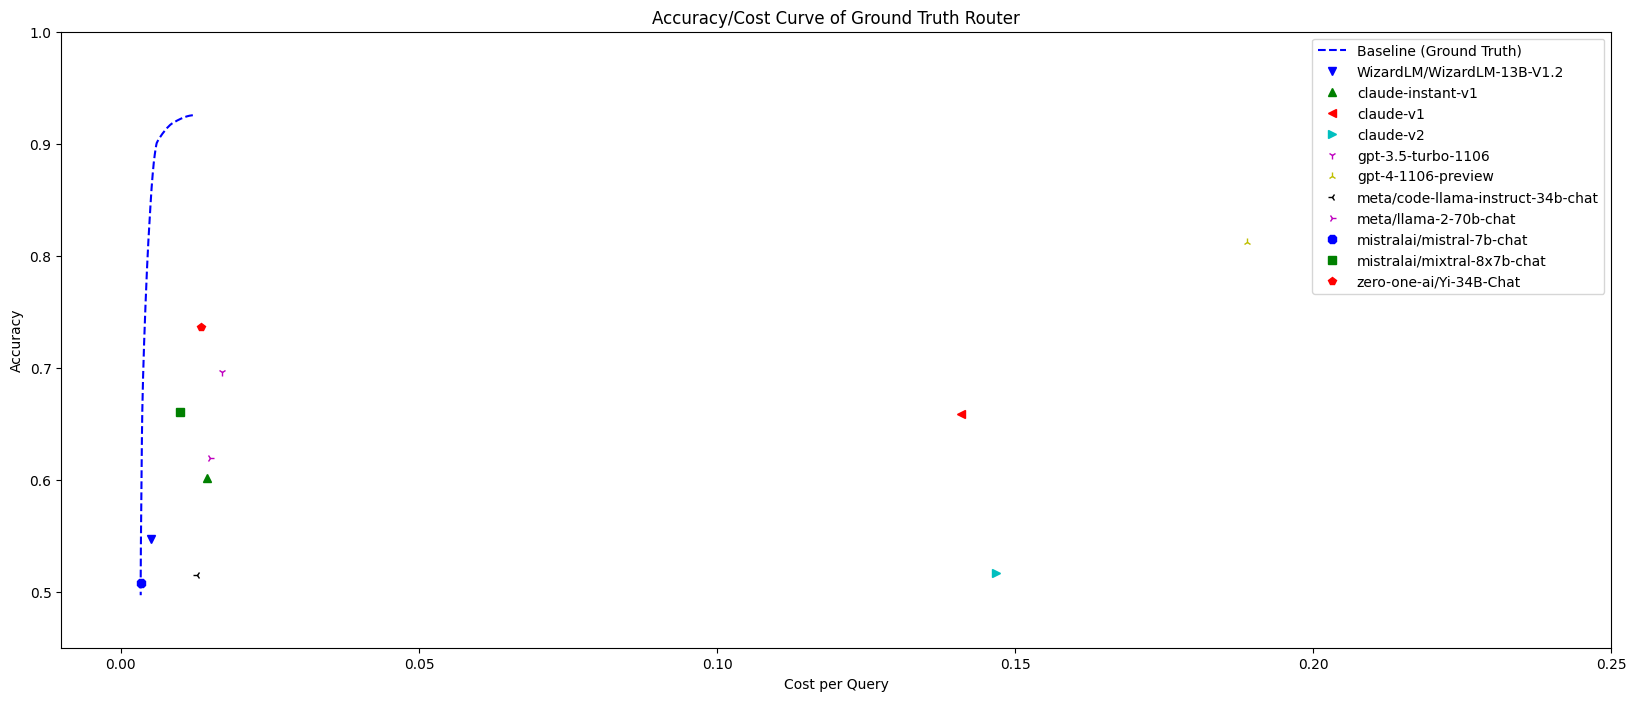

In [ ]:
plt.figure(figsize=(20, 8))
plt.plot(cost_true2[1:], acc_true2[1:], '--', color='blue', label='Baseline (Ground Truth)')


markers = ['v','^','<','>','1','2','3','4','8','s','p']
colors = ['b','g','r','c','m','y','k','m','b','g','r']

m = 0

for llm in llms:
    llm_acc_cost[llm]
    plt.plot(llm_acc_cost[llm][1], llm_acc_cost[llm][0], markers[m], color=colors[m], label=llm)
    m += 1

plt.xlim(-0.01, 0.25)
plt.ylim(0.45, 1)
plt.xlabel('Cost per Query')
plt.ylabel('Accuracy')
plt.title('Accuracy/Cost Curve of Ground Truth Router')
plt.legend()

In [11]:
n = y_acc_test.shape[0]
'''    
y_cost_pred_ = y_cost_pred/np.max(y_cost_pred)
y_cost_test_ = y_cost_test/np.max(y_cost_test)

model_idx = ((1 - lam) * y_acc_pred - lam * y_cost_pred_).argmax(axis = 1)

final_acc = np.zeros(n)
final_cost = np.zeros(n)

idx = list_append.index(llm)


utilization = sum([1 for i in model_idx if i==idx])/len(model_idx)

#final_acc = y_acc_test[np.arange(n), model_idx]
#final_cost = y_cost_test_[np.arange(n), model_idx]
final_cost = y_cost_test_[np.arange(n), model_idx]
'''

'    \ny_cost_pred_ = y_cost_pred/np.max(y_cost_pred)\ny_cost_test_ = y_cost_test/np.max(y_cost_test)\n\nmodel_idx = ((1 - lam) * y_acc_pred - lam * y_cost_pred_).argmax(axis = 1)\n\nfinal_acc = np.zeros(n)\nfinal_cost = np.zeros(n)\n\nidx = list_append.index(llm)\n\n\nutilization = sum([1 for i in model_idx if i==idx])/len(model_idx)\n\n#final_acc = y_acc_test[np.arange(n), model_idx]\n#final_cost = y_cost_test_[np.arange(n), model_idx]\nfinal_cost = y_cost_test_[np.arange(n), model_idx]\n'

In [ ]:
import copy
import os
import pickle
from skactiveml.regressor import NICKernelRegressor
from skactiveml.pool import GreedySamplingX, GreedySamplingTarget
from datetime import datetime

def route_and_return_top_k(regressors, idx, k):


    values = np.zeros(11)

    for lam in np.arange(0, 1.01, 0.01):


        
        x = X_train[idx]
        y = y_acc_train[idx, :]
        y_cost = (y_cost_train/np.max(y_cost_train))[idx, :]

        y_pred = np.zeros((len(llms),))

        for llm in llms:  
            llm_idx = list_append.index(llm)
            y_pred[llm_idx] = regressors[llm].predict([x])[0]

    
        
        model_idx = np.argsort((1 - lam) * y_pred - lam * y_cost)

        sorted_indices = np.argsort(model_idx) 

        value = np.zeros(11)
        i = 0

        for idx__v in sorted_indices:
            value[idx__v] = i
            i += 1
        
        values += value
        

    

    return [llms[idx__] for idx__ in np.argsort(values)[11-k:]]
    

def prescriptive_active_learn(regressors__, left_out, k, n_iterations, batch_size, directory='prescriptive_al', indices__ = None):

   
    
    regressors = copy.deepcopy(regressors__)
    
    regressors[left_out] = NICKernelRegressor(metric_dict={'gamma': 15.0})

    

    qs = GreedySamplingTarget(random_state=42)

    X = X_train 

    y_true = y_acc_train[:, list_append.index(left_out)]
    y_labeled = np.full_like(y_true, np.nan)



    
    y_labeled[indices__] = y_true[indices__]    
    regressors[left_out].fit(X, y_labeled)

    os.makedirs(directory, exist_ok=True)


    
    for i in range(n_iterations):
        current_time = datetime.now()
        indices, utils = qs.query(X=X, y=y_labeled, reg=regressors[left_out], fit_reg=True, return_utilities=True, batch_size=batch_size)
        indices_prescriptive = []
        

        for idx in indices:
            if left_out in route_and_return_top_k(regressors, idx, k):
                indices_prescriptive.append(idx)

        

        #y_prescriptive[indices_prescriptive] = y_true[indices_prescriptive]
        y_labeled[indices_prescriptive] = y_true[indices_prescriptive]

        regressors[left_out].fit(X, y_labeled)

                    
        with open(directory +'/prescr_iter'+ str(i), 'wb') as file:
            pickle.dump(indices_prescriptive, file)

        with open(directory +'/pred_iter'+ str(i), 'wb') as file:
            pickle.dump(indices, file)

        
        # Extract the seconds component
        print('Iteration ', i+1, ', time (in seconds) ', (datetime.now() - current_time).total_seconds(), sep='')
    



In [ ]:
directory = 'init_indices_no_small_categories_opt'
total_indices = np.array(list(range(50)))

for i in range(150):
                        
    with open(directory +'/'+ 'iter' + '_' + str(i), 'rb') as file:
        indices__ = pickle.load(file)

    total_indices = np.concatenate((total_indices, indices__))

directory = 'prescriptive_al_final_informs'
prescr_indices = total_indices[:2000]

for i in range(60):
                        
    with open(directory +'/prescr_iter'+ str(i), 'rb') as file:
        indices__ = pickle.load(file)

    prescr_indices = np.concatenate((prescr_indices, indices__))

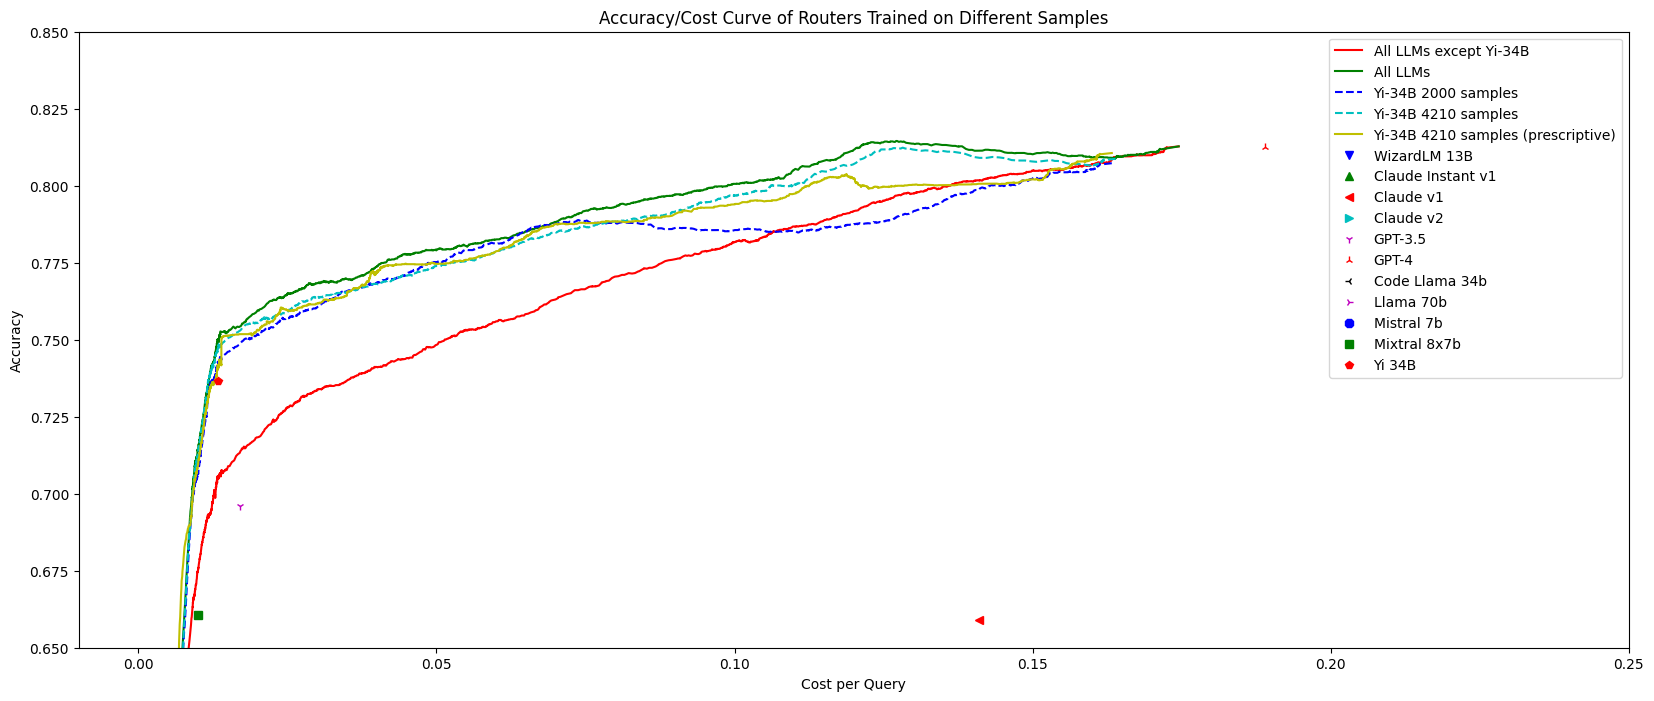

In [23]:
def plot_cost_accuracy_curve(baseline, leave_one_out, active_learning_acc=None, active_learning_cost=None, samples=None, second=None, second_samples=None):
    plt.figure(figsize=(20, 8))

    plt.ylim(0.65, 0.85)
    leave_one_out_acc = leave_one_out[0]
    leave_one_out_cost = leave_one_out[1]
    
    plt.plot(leave_one_out_cost, leave_one_out_acc, '-', color='red', label='All LLMs except Yi-34B')

    baseline_acc = baseline[0]
    baseline_cost = baseline[1]
    
    plt.plot(baseline[1], baseline[0], '-', color='green', label='All LLMs')

    colors = ['b','c','m','y','k']
    
    for i in range(len(active_learning_acc)):
        plt.plot(active_learning_cost[i], active_learning_acc[i], '--', color=colors[i % len(colors)], label='Yi-34B ' + str(samples[i]) + ' samples')

    if second:
        for i in range(len(second_samples)):
            plt.plot(active_learning_cost[i], second[i], '-', color=colors[(i+3) % len(colors)], label='Yi-34B ' + str(second_samples[i]) + ' samples (prescriptive)')


    plt.title
    
    markers = ['v','^','<','>','1','2','3','4','8','s','p']
    
    colors = ['b','g','r','c','m','r','k','m','b','g','r']
    
    m = 0
    
    for llm, shortname in zip(llms, llms_short):
        llm_acc_cost[llm]
        plt.plot(llm_acc_cost[llm][1], llm_acc_cost[llm][0], markers[m], color=colors[m], label=shortname)
        m += 1
    
    plt.xlim(-0.01, 0.25)
    plt.xlabel('Cost per Query')
    plt.ylabel('Accuracy')
    plt.title('Accuracy/Cost Curve of Routers Trained on Different Samples')
    plt.legend()

    

baseline = (acc_true1, cost_true1)
leave_one_out = (acc_true_zero, cost_true_zero)

num_of_samples = [2000, 4210]
num_of_prescr_samples = [4210]
active_accuracies = []

prescr_accuracies = []
active_costs = []

for llm in llms: 
    if llm == 'zero-one-ai/Yi-34B-Chat':
        pass
    else:
        idx = list_append.index(llm)
        y_acc_pred__[:, idx] = y_acc_pred[:, idx]

#print(y_acc_pred__)

for samples in num_of_samples:


    
    regressor__ = NICKernelRegressor(metric_dict={'gamma': 15.0})
    y_true = y_acc_train[:, list_append.index('zero-one-ai/Yi-34B-Chat')]

    y__ = np.full_like(y_true, np.nan)
    indices__ = total_indices[0:samples].astype(np.int64)
    y__[indices__] = y_true[indices__]  

    regressor__.fit(X_train, y__)

    

    acc_true__ = np.zeros(len(list(np.arange(0, 1.001, 0.0001))))
    cost_true__ = np.zeros(len(list(np.arange(0, 1.001, 0.0001))))
    
       
    
    llms = ['WizardLM/WizardLM-13B-V1.2', 'claude-instant-v1', 'claude-v1', 'claude-v2', 'gpt-3.5-turbo-1106',
           'gpt-4-1106-preview', 'meta/code-llama-instruct-34b-chat',
           'meta/llama-2-70b-chat', 'mistralai/mistral-7b-chat',
           'mistralai/mixtral-8x7b-chat', 'zero-one-ai/Yi-34B-Chat']
    
    

    for llm in ['zero-one-ai/Yi-34B-Chat']: 
        idx = list_append.index(llm)
        y_acc_pred__[:, idx] = regressor__.predict(X_test)
    
    
    for lam, i in zip(np.arange(0, 1.001, 0.0001), range(len(list(np.arange(0, 1.001, 0.0001))))):
    
        x = score_auc(y_acc_test, y_cost_test, y_acc_pred__, y_cost_test, lam)
        acc_true__[i], cost_true__[i], = x[0], x[1]     
    
    active_accuracies.append(acc_true__)
    active_costs.append(cost_true__)



for prescr_samples in num_of_prescr_samples:

    regressor__ = NICKernelRegressor(metric_dict={'gamma': 15.0})

    y__ = np.full_like(y_true, np.nan)
    indices__ = prescr_indices[0:prescr_samples].astype(np.int64)
    y__[indices__] = y_true[indices__]  

    regressor__.fit(X_train, y__)

    

    acc_true__ = np.zeros(len(list(np.arange(0, 1.001, 0.0001))))
    cost_true__ = np.zeros(len(list(np.arange(0, 1.001, 0.0001))))    
    

    for llm in ['zero-one-ai/Yi-34B-Chat']: 
        idx = list_append.index(llm)
        y_acc_pred__[:, idx] = regressor__.predict(X_test)
    
    
    for lam, i in zip(np.arange(0, 1.001, 0.0001), range(len(list(np.arange(0, 1.001, 0.0001))))):
    
        x = score_auc(y_acc_test, y_cost_test, y_acc_pred__, y_cost_test, lam)
        acc_true__[i], cost_true__[i], = x[0], x[1]     
    
    prescr_accuracies.append(acc_true__)


plot_cost_accuracy_curve(baseline, leave_one_out, active_accuracies, active_costs, num_of_samples, prescr_accuracies, num_of_prescr_samples)

In [36]:
y_acc_pred.mean(axis=0)

array([0.52794898, 0.57219375, 0.6302785 , 0.49443072, 0.66908773,
       0.78620626, 0.48707619, 0.59181128, 0.48787682, 0.63464904,
       0.69938629])

In [ ]:
import pickle
import os
from datetime import datetime
from skactiveml.regressor import NICKernelRegressor
from skactiveml.pool import GreedySamplingX, GreedySamplingTarget

left_out = 'zero-one-ai/Yi-34B-Chat'
    
regressor__ = NICKernelRegressor(metric_dict={'gamma': 15.0})

qs = GreedySamplingTarget(random_state=42)

directory='init_indices_no_small_categories_opt'

os.makedirs(directory, exist_ok=True)

X = X_train 
batch_size = 50
n_iterations = 150

y_true = y_acc_train[:, list_append.index(left_out)]
y = np.full_like(y_true, np.nan)
y[0:batch_size] = y_true[0:batch_size]   

regressor__.fit(X, y)

for i in range(n_iterations):
    current_time = datetime.now()
    indices, utils = qs.query(X=X, y=y, reg=regressor__, fit_reg=True, return_utilities=True, batch_size=batch_size, random_state=42)
    y[indices] = y_true[indices]

    regressor__.fit(X, y)

    with open(directory +'/'+ 'iter' + '_' + str(i), 'wb') as file:
        pickle.dump(indices, file)

    
    # Extract the seconds component
    print('Iteration ', i+1, ', time (in seconds) ', (datetime.now() - current_time).total_seconds(), sep='')